### References,

- Original GAN paper by Goodfellow et. el., https://arxiv.org/abs/1406.2661.
- Pytorch GAN implementation this is based on, https://www.youtube.com/watch?v=OljTVUVzPpM.


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
class Discriminator(nn.Module):
    def __init__(self, img_dim):
        """Discriminates between fake and real samples.

        A simple multilayer perceptron model is built which outputs probability of real or fake.
        Section 3 of GAN paper, https://arxiv.org/pdf/1406.2661.pdf, mentions `D` outputting a
        single scalar. `D(x)` outputs the probability that x came from data rather than generator.

        Discriminator `D` is trained to maximize probability of assigning correct label to both
        training examples  and generated samples. Sigmoid activation is used in last layer to get
        fake vs real probability.

        Args:
            img_dim: Flattened input image shape.
        """
        super(Discriminator, self).__init__()
        self.D = nn.Sequential(
            nn.Linear(img_dim, 256),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.1),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.D(x)

In [ ]:
class Generator(nn.Module):
    def __init__(self, z_dim, img_dim):
        """Generate samples to be used by Discriminator or for result.

        Another MLP to map random noise to a sample. Hyperbolic tangent activation function
        is used get values between (-1, 1) which is what input image is scaled to initially.

        Args:
            z_dim: Random noise passed to generator.
            img_dim: Flattened input image shape.
        """
        super(Generator, self).__init__()
        self.G = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.LeakyReLU(0.1),
            nn.Linear(256, img_dim),
            nn.Tanh()
        )

    def forward(self, z):
        return self.G(z)

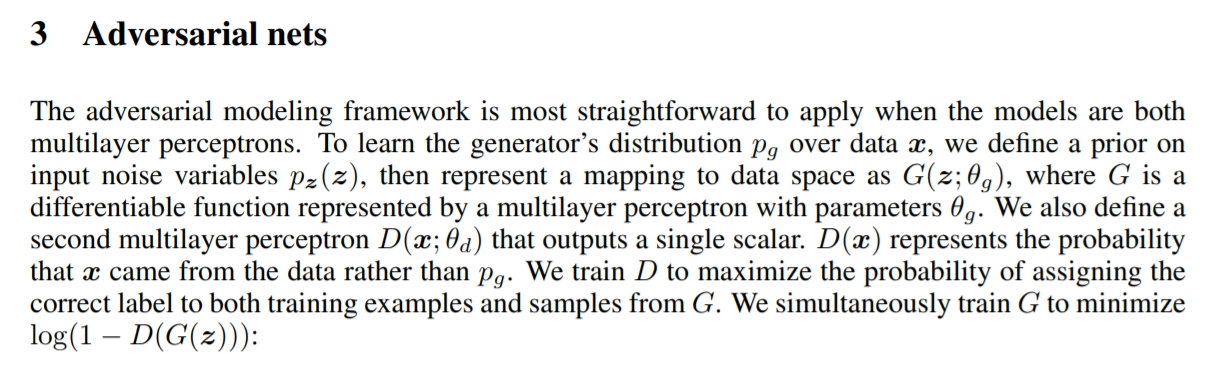

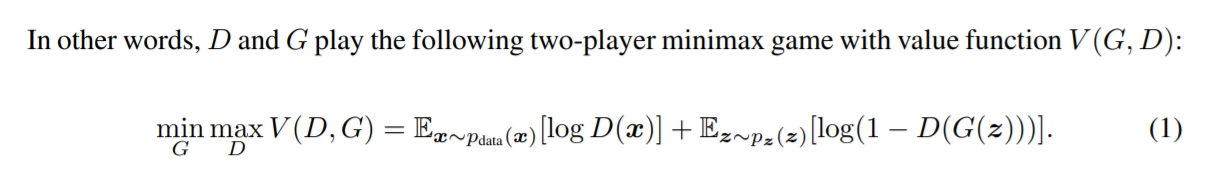

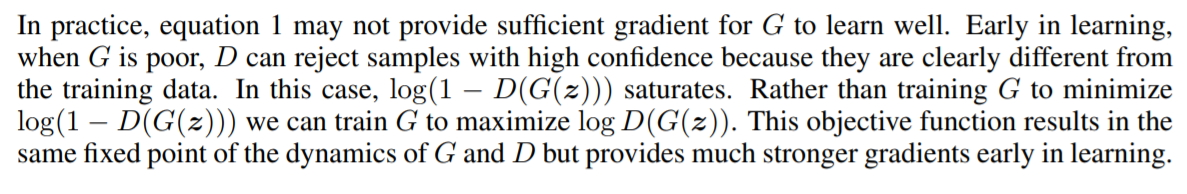

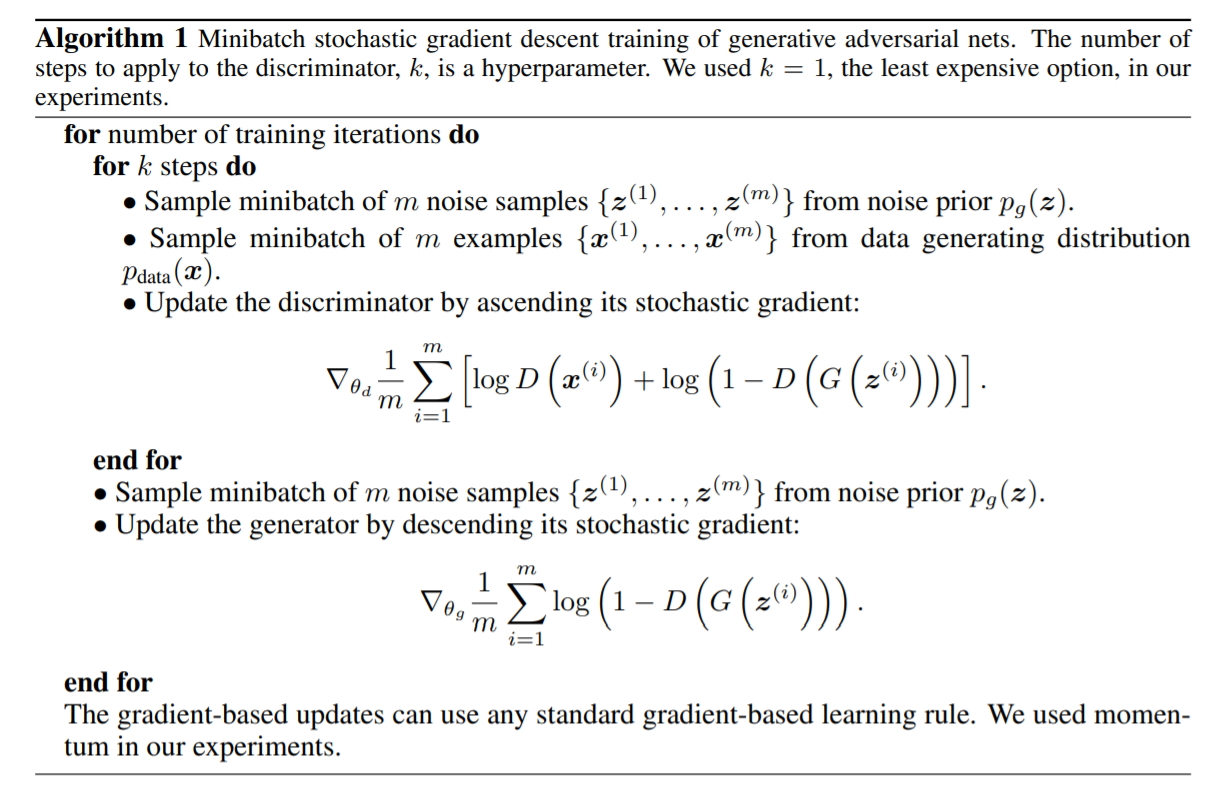

**Optimizing discriminator for K steps before doing 1 step optimization on Generator seems to really improve the result early on. Here, I have chosen K=4 for colab. A smaller K will be faster and maybe all needed for somewhat good results.**

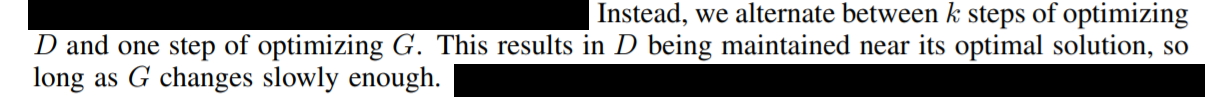

**Steps and mini batch yield loop order is different. It is not following the above algorithm exactly, but seems to produce better result than K=1 version which matches the algorithm.**

In [ ]:
class Trainer():
    def __init__(self, transforms):
        """Setup training parameters.

        Args:
            transforms: Transforms to apply to dataset
        """
        super(Trainer, self).__init__()

        # Hyperparameter setup
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.lr = 3e-4
        self.z_dim = 128
        self.image_dim = 28 * 28 * 1
        self.batch_size = 256
        self.num_epochs = 200
        self.K = 4  # Number of steps to train the discriminator.

        # Setup models
        self.D = Discriminator(self.image_dim).to(self.device)
        self.G = Generator(self.z_dim, self.image_dim).to(self.device)
        self.fixed_noise = torch.randn((self.batch_size, self.z_dim)).to(self.device)

        # Setup data transform, loading, optimizer and loss function
        self.dataset = datasets.MNIST(root='dataset/', transform=transforms, download=True)
        self.loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True)
        self.opt_D = optim.Adam(self.D.parameters(), lr=self.lr)
        self.opt_G = optim.Adam(self.G.parameters(), lr=self.lr)
        self.criterion = nn.BCELoss()

        self.writer_fake = SummaryWriter(f"runs/GAN_MNIST/fake")
        self.writer_real = SummaryWriter(f"runs/GAN_MNIST/real")
        self.step = 0

    def train(self):
        """Training loop.

        First input image from dataloader is flattened to match input dimension.
        Next, mini batch of `m` noise samples `{z^(1), ..., z^(m)}` generated from noise prior, `p_g(z)`.
        Here, the mini batch size `m` is equivalent to `batch_size`.

        Optimization function for Discriminator, `max E(log D(x) + log (1 - D(G(z)))`, with `E` expected value.

        For discriminator loss function on real data the target label is all ones since these are all real images.
        So, Binary Eross Entropy Loss function, `-(y * log(x) + (1 - y) * log(1 - x))`, becomes, `-log(x)`, as the
        values for `y` are all `1`. Here, input to the loss function is, `x = D_real`, it becomes `-log(D_real)`.

        For discriminator loss function on fake/generated data the target label is all zeros since these are all
        fake images. So, Binary Eross Entropy Loss function, `-(y * log(x) + (1 - y) * log(1 - x))`, becomes,
        `-log(1 - x)`, as the values for `y` are all `0`. Here, input to the loss function is, `x = D_fake`,
        it becomes `-log(1 - D_fake)`.

        Since the log values are negative we are instead doing gradient ascent to maximize.

        In section 3 of the GAN paper the third equation mentions doing `log(1 - D(G(z)))` may not provide sufficient
        gradient and it saturates. This happens early in training generator results are poor and discriminator discards
        these as it finds the generated image is not from the same distribution as training images.
        The paper mentions instead of minimizing `log(1 - D(G(z)))`, maximize `log(D(G(z)))` as objective function
        result is same but provides strong gradients in early training.

        As I understand, `min -log(D(G(z)))` is equivalent to, `max log(D(G(z)))` as the gradient update will
        be opposite.
        """
        for epoch in range(self.num_epochs):
            for batch_idx, (real, _) in enumerate(self.loader):
                real = real.view(-1, 784).to(self.device)
                current_batch_size = real.shape[0]

                # Train Discriminator, `max E(log D(x) + log (1 - D(G(z)))`
                for k in range(self.K):
                    noise = torch.randn((current_batch_size, self.z_dim)).to(self.device)
                    fake = self.G(noise)  # Generator output on the noise batch generating batch of flattened images.

                    D_real = self.D(real).view(-1)
                    loss_D_real = self.criterion(D_real, torch.ones_like(D_real))
                    D_fake = self.D(fake.detach()).view(-1) # Fake samples detached from computational graph for reuse.
                    loss_D_fake = self.criterion(D_fake, torch.zeros_like(D_fake))

                    loss_D = (loss_D_real + loss_D_fake) / 2
                    self.D.zero_grad()
                    loss_D.backward()
                    self.opt_D.step()

                # Train Generator, `min log(1 - D(G(z)))`, instead use, `max log(D(G(z)))` as mentioned above.
                output = self.D(fake).view(-1)
                loss_G = self.criterion(output, torch.ones_like(output))
                self.G.zero_grad()
                loss_G.backward()
                self.opt_G.step()

                # Tensorboard code
                if batch_idx == 0:
                    print(
                        f"Epoch [{epoch} / {self.num_epochs}] \ "
                        f"Loss D: {loss_D:.4f}, loss G: {loss_G:.4f}"
                    )

                    with torch.no_grad():
                        fake_imgs = self.G(self.fixed_noise).reshape(-1, 1, 28, 28)
                        real_imgs = real.reshape(-1, 1, 28, 28)

                        img_grid_fake = torchvision.utils.make_grid(fake_imgs, normalize=True)
                        img_grid_real = torchvision.utils.make_grid(real_imgs, normalize=True)

                        self.writer_fake.add_image(
                            "MNIST Fake Images", img_grid_fake, global_step=self.step
                        )
                        self.writer_real.add_image(
                            "MNIST Real Images", img_grid_real, global_step=self.step
                        )

                        self.step += 1


**Need to check how get output from latest run log properly. Temporary solution is to delete the log folder to only get latest data.**

In [ ]:
!pwd

/content


In [ ]:
!rm -r 'runs'

In [ ]:
%tensorboard --logdir runs

In [ ]:
if __name__ == '__main__':
    # Setup data transformation, loading, optimizer and loss function
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,))
    ])

    trainer = Trainer(transform)
    trainer.train()

Epoch [0 / 200] \ Loss D: 0.3557, loss G: 0.7909
Epoch [1 / 200] \ Loss D: 0.0169, loss G: 3.8240
Epoch [2 / 200] \ Loss D: 0.0057, loss G: 5.1663
Epoch [3 / 200] \ Loss D: 0.0064, loss G: 6.4260
Epoch [4 / 200] \ Loss D: 0.0121, loss G: 7.0313
Epoch [5 / 200] \ Loss D: 0.0146, loss G: 6.5564
Epoch [6 / 200] \ Loss D: 0.0436, loss G: 5.1528
Epoch [7 / 200] \ Loss D: 0.0099, loss G: 5.7128
Epoch [8 / 200] \ Loss D: 0.0335, loss G: 4.2457
Epoch [9 / 200] \ Loss D: 0.0839, loss G: 5.7595
Epoch [10 / 200] \ Loss D: 0.0564, loss G: 5.2292
Epoch [11 / 200] \ Loss D: 0.0676, loss G: 4.3726
Epoch [12 / 200] \ Loss D: 0.1019, loss G: 4.1944
Epoch [13 / 200] \ Loss D: 0.1653, loss G: 4.7873
Epoch [14 / 200] \ Loss D: 0.1194, loss G: 4.1790
Epoch [15 / 200] \ Loss D: 0.1439, loss G: 3.4778
Epoch [16 / 200] \ Loss D: 0.1388, loss G: 4.6340
Epoch [17 / 200] \ Loss D: 0.1436, loss G: 3.9049
Epoch [18 / 200] \ Loss D: 0.1320, loss G: 3.8080
Epoch [19 / 200] \ Loss D: 0.1236, loss G: 3.8178
Epoch [20 

KeyboardInterrupt: ignored